In [1]:
#Here, all the necessary imports are made.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import csv
import sys
import sys
print("Python version:", sys.version)
!pip list

Python version: 3.11.11 (main, Feb 25 2025, 13:22:37) [Clang 16.0.0 (clang-1600.0.26.6)]
Package                      Version
---------------------------- --------------
absl-py                      2.2.0
anyio                        4.9.0
appnope                      0.1.4
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.5
attrs                        25.3.0
babel                        2.17.0
beautifulsoup4               4.13.3
bleach                       6.2.0
certifi                      2025.1.31
cffi                         1.17.1
charset-normalizer           3.4.1
cloudpickle                  3.1.1
comm                         0.2.2
contourpy                    1.3.1
cycler                       0.12.1
debugpy                      1.8.13
decorator                    5.2.1
defusedxml                   0.7.1
executing    

In [2]:
DATA_DIR_2 = '/Users/larsheijnen/Thesis/Final/MDS-UPDRS_Part_III_21Mar2025.csv'
machine_learning_data = pd.read_csv(DATA_DIR_2)

In [3]:
# Convert date columns to datetime where possible
for col in ['INFODT', 'EXAMDT', 'ORIG_ENTRY', 'LAST_UPDATE']:
    if col in machine_learning_data.columns:
        machine_learning_data[col] = pd.to_datetime(machine_learning_data[col], errors='coerce')

# Convert specific date columns
machine_learning_data['EXAMDT'] = pd.to_datetime(machine_learning_data['EXAMDT'], errors='coerce')
machine_learning_data['INFODT'] = pd.to_datetime(machine_learning_data['INFODT'], errors='coerce')

# Fallback: fill missing EXAMDT with INFODT
machine_learning_data['EXAMDT'] = machine_learning_data['EXAMDT'].fillna(machine_learning_data['INFODT'])

# Replace 101 values with NaN in NP3 columns
np3_cols = [col for col in machine_learning_data.columns if col.startswith('NP3') and col != 'NP3TOT']
machine_learning_data[np3_cols] = machine_learning_data[np3_cols].replace(101, np.nan)

#Check outliers or wrong values
np3_cols = [col for col in machine_learning_data.columns if col.startswith('NP3') and col != 'NP3TOT']

# Find out-of-range values
out_of_range = (machine_learning_data[np3_cols] < 0) | (machine_learning_data[np3_cols] > 4)
if out_of_range.any().any():
    print("Warning: Out-of-range NP3 scores detected!")
    display(machine_learning_data.loc[out_of_range.any(axis=1), ['PATNO', 'EXAMDT'] + np3_cols])
else:
    print("All NP3 scores within expected range (0–4). Ignored NP3TOT.")

# Drop rows where NP3TOT is NaN
machine_learning_data = machine_learning_data.dropna(subset=['NP3TOT'])
print(f"Remaining rows after dropping NaN NP3TOT: {len(machine_learning_data)}")


All NP3 scores within expected range (0–4). Ignored NP3TOT.
Remaining rows after dropping NaN NP3TOT: 26109


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_78359/2176198891.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  machine_learning_data[col] = pd.to_datetime(machine_learning_data[col], errors='coerce')
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_78359/2176198891.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  machine_learning_data[col] = pd.to_datetime(machine_learning_data[col], errors='coerce')
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_78359/2176198891.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  machine_learning_d

In [4]:
motor_features = [
    'PATNO', 'EVENT_ID', 'INFODT',  # Identifying information

    # MDS-UPDRS Part III scores
    'NP3SPCH', 'NP3FACXP',
    'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL',  # Rigidity
    'NP3FTAPR', 'NP3FTAPL',  # Finger tapping
    'NP3HMOVR', 'NP3HMOVL',  # Hand movements
    'NP3PRSPR', 'NP3PRSPL',  # Pronation-supination
    'NP3TTAPR', 'NP3TTAPL',  # Toe tapping
    'NP3LGAGR', 'NP3LGAGL',  # Leg agility
    'NP3RISNG',  # Arising from chair
    'NP3GAIT', 'NP3FRZGT',  # Gait and freezing
    'NP3PSTBL',  # Postural stability
    'NP3POSTR',  # Posture
    'NP3BRADY',  # Body bradykinesia
    'NP3PTRMR', 'NP3PTRML',  # Postural tremor
    'NP3KTRMR', 'NP3KTRML',  # Kinetic tremor
    'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON',  # Rest tremor
    'NP3TOT'  # Total score (needed for target creation)
]


In [5]:
# Keep only relevant columns available in the dataset
motor_df = machine_learning_data[[col for col in motor_features if col in machine_learning_data.columns]].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Initial motor assessment DataFrame shape: {motor_df.shape}")

Initial motor assessment DataFrame shape: (26109, 37)


In [6]:
# Define the expected components of NP3TOT based on MDS-UPDRS guidelines
# These are the column names as they appear in your CSV/DataFrame
expected_np3_components = [
    'NP3SPCH',  # 3.1
    'NP3FACXP', # 3.2
    'NP3RIGN',  # 3.3a
    'NP3RIGRU', # 3.3b
    'NP3RIGLU', # 3.3c
    'NP3RIGRL', # 3.3d
    'NP3RIGLL', # 3.3e
    'NP3FTAPR', # 3.4a
    'NP3FTAPL', # 3.4b
    'NP3HMOVR', # 3.5a
    'NP3HMOVL', # 3.5b
    'NP3PRSPR', # 3.6a
    'NP3PRSPL', # 3.6b
    'NP3TTAPR', # 3.7a
    'NP3TTAPL', # 3.7b
    'NP3LGAGR', # 3.8a
    'NP3LGAGL', # 3.8b
    'NP3RISNG', # 3.9
    'NP3GAIT',  # 3.10
    'NP3FRZGT', # 3.11
    'NP3PSTBL', # 3.12
    'NP3POSTR', # 3.13
    'NP3BRADY', # 3.14
    'NP3PTRMR', # 3.15a (Postural Tremor Right Hand)
    'NP3PTRML', # 3.15b (Postural Tremor Left Hand)
    'NP3KTRMR', # 3.16a (Kinetic Tremor Right Hand)
    'NP3KTRML', # 3.16b (Kinetic Tremor Left Hand)
    'NP3RTARU', # 3.17a (Rest Tremor Right Upper Extremity)
    'NP3RTALU', # 3.17b (Rest Tremor Left Upper Extremity)
    'NP3RTARL', # 3.17c (Rest Tremor Right Lower Extremity)
    'NP3RTALL', # 3.17d (Rest Tremor Left Lower Extremity)
    'NP3RTALJ', # 3.17e (Rest Tremor Jaw)
    'NP3RTCON'  # 3.18 (Rest Tremor Constancy)
]

# motor_features is defined in a previous cell.
# Let's find which features in motor_features are part of the expected NP3 components
actual_np3_sum_components_in_motor_features = [col for col in motor_features if col in expected_np3_components]

print(f"Number of expected NP3 components: {len(expected_np3_components)}")
print(f"Expected NP3 components: {expected_np3_components}")
print("-" * 50)
print(f"Number of NP3 sum components found in your 'motor_features' list: {len(actual_np3_sum_components_in_motor_features)}")
print(f"Actual NP3 sum components from 'motor_features': {actual_np3_sum_components_in_motor_features}")
print("-" * 50)

# Verify the sum for a few rows in the original motor_df (before any dropping of NaNs for specific columns if that happens later)
# Make sure motor_df is loaded and NP3TOT is present
if 'motor_df' in locals() and 'NP3TOT' in motor_df.columns:
    # Calculate the sum of these components for each row
    motor_df['Calculated_NP3TOT'] = motor_df[actual_np3_sum_components_in_motor_features].sum(axis=1)

    # Compare with the original NP3TOT
    # We'll check the first 5 rows and a few random rows where NP3TOT is not 0 (if any)
    comparison_df = motor_df[['NP3TOT', 'Calculated_NP3TOT']].copy()
    comparison_df['Difference'] = comparison_df['NP3TOT'] - comparison_df['Calculated_NP3TOT']

    print("Comparison of NP3TOT with sum of its identified components (first 5 rows):")
    print(comparison_df.head())
    print("-" * 50)

    # Check if all differences are zero (or very close to zero, allowing for potential float precision issues if data was manipulated)
    if comparison_df['Difference'].abs().sum() < 1e-5: # A small tolerance for floating point arithmetic
        print("Verification successful: NP3TOT matches the sum of the identified components for all rows.")
    else:
        print("Verification FAILED: NP3TOT does NOT match the sum of the identified components for all rows.")
        print(f"Number of rows with mismatch: {len(comparison_df[comparison_df['Difference'].abs() > 1e-5])}")
        print("Rows with discrepancies:")
        print(comparison_df[comparison_df['Difference'].abs() > 1e-5].head())

    # It's good practice to drop the temporary column if you don't need it later
    # motor_df.drop(columns=['Calculated_NP3TOT'], inplace=True)
else:
    print("motor_df not found or NP3TOT column is missing. Cannot perform sum verification.")


Number of expected NP3 components: 33
Expected NP3 components: ['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON']
--------------------------------------------------
Number of NP3 sum components found in your 'motor_features' list: 33
Actual NP3 sum components from 'motor_features': ['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3

In [7]:
print("Missing values in motor_df BEFORE any dropna (immediately after creation):")
print(f"Shape of motor_df: {motor_df.shape}")
print("\nNaNs per column in motor_features + NP3TOT:")
nan_counts = motor_df[motor_features + ['NP3TOT']].isnull().sum()
print(nan_counts[nan_counts > 0]) # Only print columns that have NaNs

print(f"\nTotal rows with any NaN in motor_features: {motor_df[motor_features].isnull().any(axis=1).sum()}")
print(f"Total rows with NaN in NP3TOT: {motor_df['NP3TOT'].isnull().sum()}")

# Display a few rows that have NaNs in any of the motor_feature columns for context
if motor_df[motor_features].isnull().any(axis=1).sum() > 0:
    print("\nExample rows with NaNs in motor_features:")
    print(motor_df[motor_df[motor_features].isnull().any(axis=1)].head())

Missing values in motor_df BEFORE any dropna (immediately after creation):
Shape of motor_df: (26109, 38)

NaNs per column in motor_features + NP3TOT:
Series([], dtype: int64)

Total rows with any NaN in motor_features: 0
Total rows with NaN in NP3TOT: 0


In [8]:
motor_df.sort_values(['PATNO', 'INFODT'], inplace=True)

motor_df['days_since_baseline'] = motor_df.groupby('PATNO')['INFODT'].transform(lambda x: (x - x.min()).dt.days)

# --- Create the Target Variable: NP3TOT of the *next* visit ---
motor_df['NP3TOT_next_visit'] = motor_df.groupby('PATNO')['NP3TOT'].shift(-1)

# --- Create Lag Features (Example: Previous NP3TOT) ---
# This demonstrates adding explicit time features. Can add more lags or differences.
motor_df['NP3TOT_lag1'] = motor_df.groupby('PATNO')['NP3TOT'].shift(1)
motor_df['NP3TOT_diff1'] = motor_df.groupby('PATNO')['NP3TOT'].diff(1)
# Add lag 2 features
motor_df['NP3TOT_lag2'] = motor_df.groupby('PATNO')['NP3TOT'].shift(2)
motor_df['NP3TOT_diff2'] = motor_df.groupby('PATNO')['NP3TOT'].diff(2)
# Add lag 3 features
motor_df['NP3TOT_lag3'] = motor_df.groupby('PATNO')['NP3TOT'].shift(3)
motor_df['NP3TOT_diff3'] = motor_df.groupby('PATNO')['NP3TOT'].diff(3)

motor_df['days_since_prev1'] = motor_df.groupby('PATNO')['INFODT'].diff(1).dt.days
motor_df['days_since_prev2'] = motor_df.groupby('PATNO')['INFODT'].diff(2).dt.days
motor_df['days_since_prev3'] = motor_df.groupby('PATNO')['INFODT'].diff(3).dt.days

In [9]:
# Drop rows where the target ('NP3TOT_next_visit') is NaN (these are the last visits per patient)
# Also drop rows where lag features are NaN (first visits)
progression_df = motor_df.dropna(subset=[
    'NP3TOT_next_visit', 
    'NP3TOT_lag1', 'NP3TOT_diff1', 
    'NP3TOT_lag2', 'NP3TOT_diff2',
    'NP3TOT_lag3', 'NP3TOT_diff3',
    'days_since_prev1', 'days_since_prev2', 'days_since_prev3'
]).copy()

print(f"\nShape after creating target and lag features & dropping NaNs: {progression_df.shape}")


Shape after creating target and lag features & dropping NaNs: (14182, 49)


In [10]:
# Original selection of NP3 items (current visit)
individual_np3_items = [col for col in progression_df.columns if 
                        col.startswith('NP3') and 
                        col not in ['NP3TOT', 'NP3TOT_next_visit'] and
                        not col.startswith('NP3TOT_lag') and 
                        not col.startswith('NP3TOT_diff')]

# Explicitly list all engineered features to ensure no overlap and correct selection
engineered_features = [
    'days_since_baseline',
    'NP3TOT_lag1', 'NP3TOT_diff1',
    'NP3TOT_lag2', 'NP3TOT_diff2',
    'NP3TOT_lag3', 'NP3TOT_diff3',
    'days_since_prev1', 'days_since_prev2', 'days_since_prev3'
]

feature_cols = individual_np3_items + engineered_features

# Ensure all listed engineered_features actually exist in progression_df.columns to avoid errors
feature_cols = [col for col in feature_cols if col in progression_df.columns]
# Remove duplicates just in case, and maintain order
from collections import OrderedDict
feature_cols = list(OrderedDict.fromkeys(feature_cols))


X = progression_df[feature_cols]
y = progression_df['NP3TOT_next_visit'] # y definition remains the same
groups = progression_df['PATNO'] # groups definition remains the same

print(f"\nCorrected Feature shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print(f"Group shape: {groups.shape}")
print("\nCorrected Features used:")
print(X.columns.tolist())
print(f"\nNumber of features: {len(X.columns.tolist())}")


Corrected Feature shape (X): (14182, 43)
Target shape (y): (14182,)
Group shape: (14182,)

Corrected Features used:
['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'days_since_baseline', 'NP3TOT_lag1', 'NP3TOT_diff1', 'NP3TOT_lag2', 'NP3TOT_diff2', 'NP3TOT_lag3', 'NP3TOT_diff3', 'days_since_prev1', 'days_since_prev2', 'days_since_prev3']

Number of features: 43


In [11]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test = groups.iloc[test_idx]

print(f"\nTrain shapes: X={X_train.shape}, y={y_train.shape}, groups={groups_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}, groups={groups_test.shape}")
print(f"Number of unique patients in train: {groups_train.nunique()}")
print(f"Number of unique patients in test: {groups_test.nunique()}")

# Verify no patient overlap (should be empty)
train_patients = set(groups_train.unique())
test_patients = set(groups_test.unique())
print(f"Overlap patients: {train_patients.intersection(test_patients)}")


Train shapes: X=(11219, 43), y=(11219,), groups=(11219,)
Test shapes: X=(2963, 43), y=(2963,), groups=(2963,)
Number of unique patients in train: 1431
Number of unique patients in test: 358
Overlap patients: set()


In [12]:
scaler = StandardScaler()

# Fit scaler ONLY on training data
scaler.fit(X_train)

# Transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print("\nScaled training data head:")
X_train_scaled.head()


Scaled training data head:


,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,...,days_since_baseline,NP3TOT_lag1,NP3TOT_diff1,NP3TOT_lag2,NP3TOT_diff2,NP3TOT_lag3,NP3TOT_diff3,days_since_prev1,days_since_prev2,days_since_prev3
3,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,-0.974617,-0.976767,0.298962,...,-0.295080,-1.033336,-0.262850,-1.233880,-0.005275,-1.018118,-0.341765,0.932906,1.206844,1.509111
4,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,0.087165,0.028955,1.455133,...,0.063485,-1.169533,1.719647,-1.024075,1.471611,-1.232118,1.656549,0.789245,1.311013,1.427569
5,-0.794742,-1.134506,-0.796356,0.116804,-0.883783,-0.711267,-0.690476,-0.974617,0.028955,-0.857209,...,0.453485,-0.011855,-1.723637,-1.163945,-0.005275,-1.018118,-0.241850,0.953429,1.325894,1.596277
6,-0.794742,-1.134506,-0.796356,0.116804,-0.883783,-0.711267,-0.690476,0.087165,0.028955,-0.857209,...,1.112654,-1.101435,0.676228,0.024953,-1.060194,-1.160785,0.657392,2.359251,2.464313,2.377957
7,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,-0.974617,-0.976767,-0.857209,...,1.498724,-0.624743,-0.575876,-1.094010,0.100217,0.051883,-1.540754,0.932906,2.449432,2.456688


In [13]:
# Cell 1: Hyperparameter Search for Tree and NN Models
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# 1) Define parameter grids for tuning
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [6, 10, None],
        "min_samples_leaf": [1, 3, 5]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 4, 6]
    },
    "MLP Regressor": {
        "hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "learning_rate_init": [1e-4, 1e-3, 1e-2]
    }
}

# 2) Prepare a GroupKFold CV splitter
cv_splitter = GroupKFold(n_splits=5)

# 3) Run grid search for each model
best_models = {}
base_estimators = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "MLP Regressor": MLPRegressor(max_iter=1000, early_stopping=True, random_state=42)
}
for name, grid in param_grids.items():
    print(f"\nSearching best params for {name}...")
    gs = GridSearchCV(
        estimator=base_estimators[name],
        param_grid=grid,
        cv=cv_splitter,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=2
    )
    gs.fit(X_train_scaled.values, y_train.values, groups=groups_train)
    print(f"→ Best CV MAE: {-gs.best_score_:.3f}")
    print(f"→ Best params for {name}: {gs.best_params_}")
    best_models[name] = gs.best_estimator_


# best_params_list = []
# for name, grid in param_grids.items():
#     params = {"Model": name}
#     if hasattr(best_models[name], "get_params"):
#         params.update(best_models[name].get_params())
#     best_params_list.append(params)

rows = []
for name in param_grids:
    params = best_models[name].get_params()
    row = {"Model": name}
    for param in param_grids[name]:
        row[param] = params[param]
    rows.append(row)

# Create DataFrame and save to CSV
results_dir = "/Users/larsheijnen/Thesis/Final/results"
os.makedirs(results_dir, exist_ok=True)
df = pd.DataFrame(rows)
df.to_csv(os.path.join(results_dir, "optimal_parameters.csv"), index=False)
print(f"Best hyperparameters saved to {os.path.join(results_dir, 'optimal_parameters.csv')}")


Searching best params for Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=100; total time=   2.9s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=100; total time=   2.8s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=100; total time=   2.9s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=100; total time=   2.9s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=100; total time=   3.0s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=200; total time=   6.4s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=200; total time=   6.6s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=200; total time=   6.5s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=200; total time=   6.7s
[CV] END ..max_depth=6, min_samples_leaf=1, n_estimators=200; total time=   7.0s
[CV] END ..max_depth=6, min_samples_leaf=3, n_estimators=100; total time=   3.2s
[CV


--- Evaluating on Test Set ---
Training & testing Random Forest...


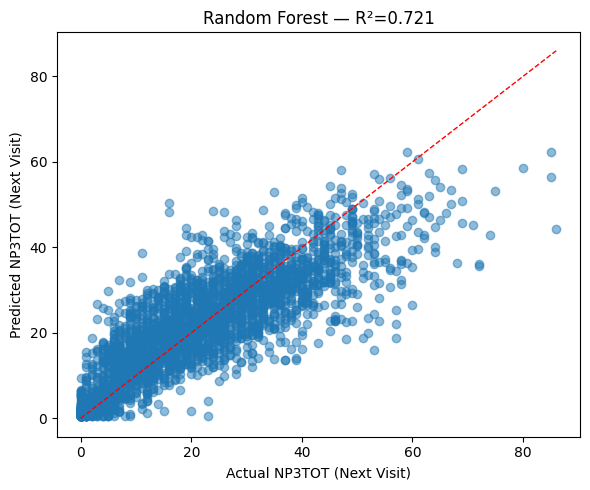

Training & testing XGBoost...


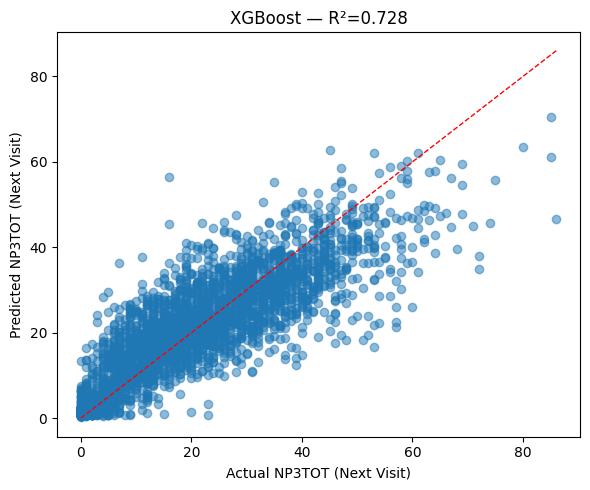

Training & testing MLP Regressor...


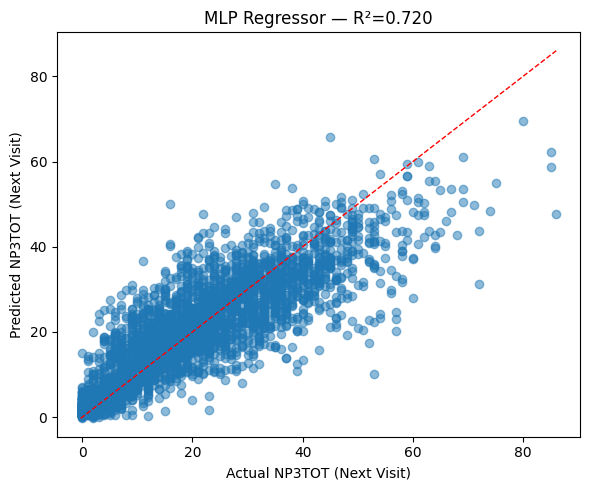

Training & testing Linear Regression...


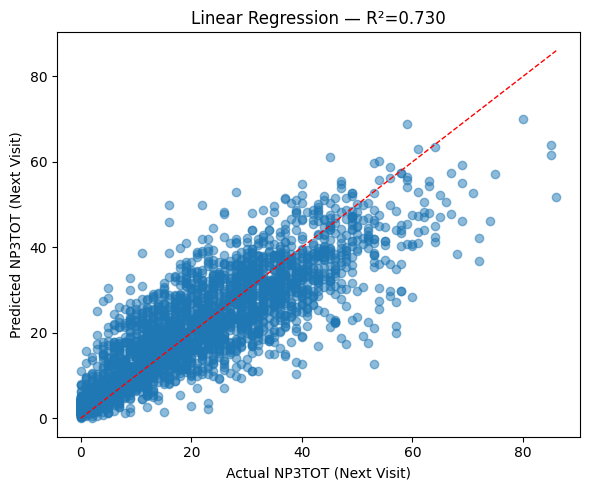


Test Set Performance Summary:
               Model    MAE   RMSE  R-squared
0      Random Forest  5.830  8.080      0.721
1            XGBoost  5.774  7.992      0.728
2      MLP Regressor  5.883  8.109      0.720
3  Linear Regression  5.825  7.956      0.730
Results saved to /Users/larsheijnen/Thesis/Final/results/results.csv


In [14]:
# Cell 2: Evaluate Tuned Models + Linear Regression on Test Set

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) Add Linear Regression baseline
best_models["Linear Regression"] = LinearRegression()

# 2) Evaluate each model on the test set
results_test = []
print("\n--- Evaluating on Test Set ---")
for name, model in best_models.items():
    print(f"Training & testing {name}...")
    model.fit(X_train_scaled.values, y_train.values)
    y_pred = model.predict(X_test_scaled.values)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    results_test.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R-squared": r2
    })

    # Plot actual vs. predicted
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi], 'r--', lw=1)
    plt.xlabel("Actual NP3TOT (Next Visit)")
    plt.ylabel("Predicted NP3TOT (Next Visit)")
    plt.title(f"{name} — R²={r2:.3f}")
    plt.tight_layout()
    plt.show()

# 3) Summarize results in a DataFrame
results_test_df = pd.DataFrame(results_test).round(3)
print("\nTest Set Performance Summary:")
print(results_test_df)

# Format R-squared to 3 decimals and use comma as decimal separator
results_test_df["R-squared"] = results_test_df["R-squared"].map(lambda x: f"{x:.3f}".replace('.', ','))

results_dir = "/Users/larsheijnen/Thesis/Final/results"
results_test_df.to_csv(f"{results_dir}/results.csv", index=False)
print(f"Results saved to {results_dir}/results.csv")
